In [1]:
import numpy as np
import geopandas as gpd

import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import mitequinox.plot as pl
import mitequinox.sigp as sp

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.8776504.datarmor0/parcels-502090/libparcels_random_0c2f8ad8-ca4c-4f16-aef1-136cf7b589c1.so


In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
#cluster = PBSCluster() #processes=7, cores=7
#w = cluster.scale(jobs=5
#                 )
client = Client(cluster)

In [5]:
path = ut.work_data_dir
SSUV_30 = xr.open_zarr(path+'diags/SSUV_T30_lat_lon.zarr')
SSUV_60 = xr.open_zarr(path+'diags/SSUV_T60_lat_lon.zarr')

In [15]:
SSUV_30_band = xr.open_zarr(path+'diags/SSUV_T30_lat_lon_bands.zarr')

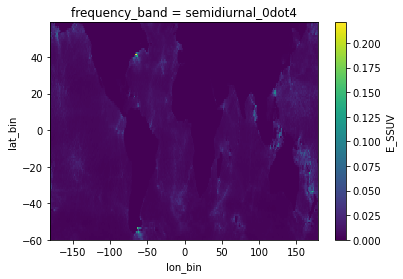

In [21]:
SSUV_30_band.E_SSUV.sel(frequency_band='semidiurnal_0dot4').plot(y='lat_bin')

In [8]:
SSUV_30 = SSUV_30.compute()
SSUV_60 = SSUV_60.compute()

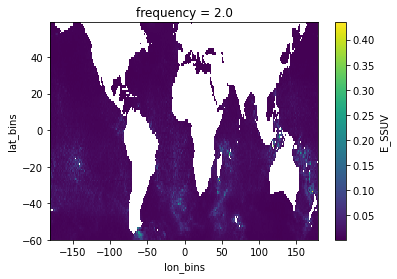

In [13]:

SSUV_30.E_SSUV.sel(frequency=2,method='nearest').plot(x='lon_bins')

In [22]:
SSUV_30_band = xr.open_zarr(path+'diags/SSUV_T30_lat_lon_bands.zarr').compute()
SSUV_60_band = xr.open_zarr(path+'diags/SSUV_T60_lat_lon_bands.zarr').compute()
SSUV_60_band_2deg = xr.open_zarr(path+'diags/SSUV_T60_lat_lon_bands_2deg.zarr').compute()
SSUV_60_2deg = xr.open_zarr(path+'diags/SSUV_T60_lat_lon_2deg.zarr').compute()

In [23]:
SSUV = SSUV_60.rename({'E_SSUV':'SSUV_T60_dl1'})
SSUV['SSUV_T30_dl1'] = SSUV_30.E_SSUV
SSUV['SSUV_T30_dl1_bands'] = SSUV_30_band.E_SSUV
SSUV['SSUV_T60_dl1_bands'] = SSUV_60_band.E_SSUV
SSUV['SSUV_T60_dl2_bands'] = SSUV_60_band_2deg.E_SSUV
SSUV['SSUV_T60_dl2'] = SSUV_60_2deg.E_SSUV

In [24]:
dir_path = ('/home1/datawork/zcaspar/mit4320/')
_ = SSUV.to_netcdf(dir_path+'SSUV.nc')

In [25]:
cluster.close()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/contextlib.py:120: UserWarning: Creating scratch directories is taking a surprisingly long time. This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)
/home1/